In [195]:
import pandas as pd
import matplotlib.pyplot as plt
import awswrangler as wr
import boto3

boto3.setup_default_session(profile_name='patricio_ferreira_fellow_dssgx_24')

bucket = "dssgx-munich-2024-bavarian-forest"
raw_data_folder = "raw-data"
preprocessed_data_folder = "preprocessed_data"

def load_csv_files_from_aws_s3(path: str, **kwargs) -> pd.DataFrame:
    """Loads individual or multiple CSV files from an AWS S3 bucket.
    Args:
        path (str): The path to the CSV files on AWS S3.
        **kwargs: Additional arguments to pass to the read_csv function.
    Returns:
        pd.DataFrame: The DataFrame containing the data from the CSV files.
    """
    df = wr.s3.read_csv(path=path, **kwargs)
    return df
df = load_csv_files_from_aws_s3(
    path="s3://dssgx-munich-2024-bavarian-forest/preprocessed_data/joined_sensor_weather_visitorcenter_2016-2024.csv"
)
df.head()

,Time,Bayerisch Eisenstein IN,Bayerisch Eisenstein OUT,Brechhäuslau IN,Brechhäuslau OUT,Deffernik IN,Deffernik OUT,Diensthüttenstraße IN,Diensthüttenstraße OUT,Felswandergebiet IN,...,Racheldiensthuette_geoeffnet,Waldschmidthaus_geoeffnet,Falkensteinschutzhaus_geoeffnet,Schwellhaeusl_geoeffnet,Temperatur,Niederschlagsmenge,Schneehoehe,GS mit,GS max,Total
0,2016-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [196]:
#drop old traffic columns

df.drop(columns= ['traffic_norm', 'traffic_abs', 'sum_IN_norm',
                  'sum_IN_abs', 'sum_OUT_norm', 'sum_OUT_abs',
                  'diff_norm', 'diff_abs'], 
                  inplace=True)

In [197]:
# Ensure the 'Time' column is in datetime format
df['Time'] = pd.to_datetime(df['Time'])

# Slice the data between the specified dates without setting 'Time' as the index
df = df[(df['Time'] >= '2023-01-01') & (df['Time'] <= '2024-07-22')]

In [198]:
import pandas as pd

def process_sensor_data(df):
    """
    Processes sensor data by melting, splitting, renaming, and pivoting to separate IN/OUT directions, 
    and then merges back non-sensor columns.

    Args:
        df (pd.DataFrame): The input DataFrame containing sensor data and other related columns.

    Returns:
        pd.DataFrame: The processed DataFrame with separate IN and OUT columns for each sensor, 
        merged back with the original non-sensor data.
    """
    # Ensure the 'Time' column is in datetime format
    df['Time'] = pd.to_datetime(df['Time'])

    # Define the renaming dictionary
    rename_dict = {
        "Bayerisch Eisenstein": ['Bayerisch Eisenstein IN', 'Bayerisch Eisenstein OUT'],
        "Brechhäuslau": ['Brechhäuslau IN', 'Brechhäuslau OUT'],
        "Bučina": ['Bucina MERGED IN', 'Bucina MERGED OUT'],
        "Deffernik": ['Deffernik IN', 'Deffernik OUT'],
        "Diensthüttenstraße": ['Diensthüttenstraße IN', 'Diensthüttenstraße OUT'],
        "Felswandergebiet": ['Felswandergebiet IN', 'Felswandergebiet OUT'],
        "Ferdinandsthal": ['Ferdinandsthal IN', 'Ferdinandsthal OUT'],
        "Fredenbrücke": ['Fredenbrücke IN', 'Fredenbrücke OUT'],
        "Gfäll": ['Gfäll IN', 'Gfäll OUT'],
        "Gsenget": ['Gsenget IN', 'Gsenget OUT'],
        "Klingenbrunner Wald": ['Klingenbrunner Wald IN', 'Klingenbrunner Wald OUT'],
        "Klosterfilz": ['Klosterfilz IN', 'Klosterfilz OUT'],
        "Racheldiensthütte": ['Racheldiensthütte IN', 'Racheldiensthütte OUT'],
        "Sagwassersäge": ['Sagwassersäge IN','Sagwassersäge OUT'],
        "Scheuereck": ['Scheuereck IN', 'Scheuereck OUT'],
        "Schillerstraße": ['Schillerstraße IN', 'Schillerstraße OUT'],
        "Schwarzbachbrücke": ['Schwarzbachbrücke IN', 'Schwarzbachbrücke OUT'],
        "TFG Falkenstein 1": ['Falkenstein 1 MERGED IN', 'Falkenstein 1 MERGED OUT'],
        "TFG Falkenstein 2": ['Falkenstein 2 IN', 'Falkenstein 2 OUT'],
        "TFG Lusen 1": ['Lusen 1 MERGED IN', 'Lusen 1 MERGED OUT'],
        "TFG Lusen 2": ['Lusen 2 IN', 'Lusen 2 OUT'],
        "TFG Lusen 3": ['Lusen 3 IN', 'Lusen 3 OUT'],
        "Trinkwassertalsperre": ['Trinkwassertalsperre MERGED IN', 'Trinkwassertalsperre MERGED OUT'],
        "Waldhausreibe": ['Waldhausreibe IN', 'Waldhausreibe OUT'],
        "Waldspielgelände": ['Waldspielgelände IN', 'Waldspielgelände OUT'],
        "Wistlberg": ['Wistlberg IN', 'Wistlberg OUT'],
    }

    # Flatten the renaming dictionary to map sensors to their IN/OUT variants
    rename_map = {sensor: name for name, sensors in rename_dict.items() for sensor in sensors}

    # List of all sensor columns
    melt_columns = list(rename_map.keys())

    # Columns that will be preserved during melting
    id_vars = [
        'Time', 'Temperature (°C)', 'Relative Humidity (%)', 'Precipitation (mm)',
        'Wind Speed (km/h)', 'Sunshine Duration (min)', 'Tag', 'Monat', 'Jahr', 'Wochentag',
        'Wochenende', 'Jahreszeit', 'Laubfärbung', 'Besuchszahlen_HEH', 'Besuchszahlen_HZW',
        'Besuchszahlen_WGM', 'Parkpl_HEH_PKW', 'Parkpl_HEH_BUS', 'Parkpl_HZW_PKW', 'Parkpl_HZW_BUS',
        'Schulferien_Bayern', 'Schulferien_CZ', 'Feiertag_Bayern', 'Feiertag_CZ', 'HEH_geoeffnet',
        'HZW_geoeffnet', 'WGM_geoeffnet', 'Lusenschutzhaus_geoeffnet', 'Racheldiensthuette_geoeffnet',
        'Waldschmidthaus_geoeffnet', 'Falkensteinschutzhaus_geoeffnet', 'Schwellhaeusl_geoeffnet',
        'Temperatur', 'Niederschlagsmenge', 'Schneehoehe', 'GS mit', 'GS max'
    ]

    # Melt the DataFrame
    df_melted = df.melt(
        id_vars=id_vars,
        value_vars=melt_columns,
        var_name='sensor_direction',
        value_name='Count'
    )

    # Split sensor_direction into 'sensor' and 'direction'
    df_melted[['sensor', 'direction']] = df_melted['sensor_direction'].str.rsplit(' ', n=1, expand=True)

    # Map the sensor names to their desired format using rename_dict
    df_melted['sensor'] = df_melted['sensor_direction'].map(rename_map)

    # Drop the original sensor_direction column
    df_melted.drop(columns=['sensor_direction'], inplace=True)

    # Extract hour from the 'Time' column
    df_melted['hour'] = df_melted['Time'].dt.hour

    # Pivot the melted DataFrame to separate IN/OUT columns
    df_pivot = df_melted.pivot_table(
        index=['Time', 'sensor', 'hour'],
        columns='direction',
        values='Count',
        aggfunc='sum'
    ).reset_index()

    # Merge back the non-sensor columns
    df_final = pd.merge(df_pivot, df[id_vars], on='Time', how='left')

    return df_final


In [199]:
df_long = process_sensor_data(df)
df_long.head()

,Time,sensor,hour,IN,OUT,Temperature (°C),Relative Humidity (%),Precipitation (mm),Wind Speed (km/h),Sunshine Duration (min),...,Lusenschutzhaus_geoeffnet,Racheldiensthuette_geoeffnet,Waldschmidthaus_geoeffnet,Falkensteinschutzhaus_geoeffnet,Schwellhaeusl_geoeffnet,Temperatur,Niederschlagsmenge,Schneehoehe,GS mit,GS max
0,2023-01-01,Bayerisch Eisenstein,0,0.0,0.0,6.4,82.0,0.0,9.0,0.0,...,True,False,511.0,True,True,9.278472,0.0,0.0,54.652778,338.0
1,2023-01-01,Brechhäuslau,0,0.0,0.0,6.4,82.0,0.0,9.0,0.0,...,True,False,511.0,True,True,9.278472,0.0,0.0,54.652778,338.0
2,2023-01-01,Bučina,0,0.0,0.0,6.4,82.0,0.0,9.0,0.0,...,True,False,511.0,True,True,9.278472,0.0,0.0,54.652778,338.0
3,2023-01-01,Deffernik,0,0.0,0.0,6.4,82.0,0.0,9.0,0.0,...,True,False,511.0,True,True,9.278472,0.0,0.0,54.652778,338.0
4,2023-01-01,Diensthüttenstraße,0,0.0,0.0,6.4,82.0,0.0,9.0,0.0,...,True,False,511.0,True,True,9.278472,0.0,0.0,54.652778,338.0


In [200]:
# add region column
location_mapping = {
    'Bayerisch Eisenstein': 'Falkenstein-Schwellhäusl', 
    'Brechhäuslau': 'Falkenstein-Schwellhäusl', 
    'Deffernik': 'Falkenstein-Schwellhäusl', 
    'TFG Falkenstein 1': 'Nationalparkzentrum Falkenstein', 
    'TFG Falkenstein 2': 'Nationalparkzentrum Falkenstein', 
    'Ferdinandsthal': 'Falkenstein-Schwellhäusl', 
    'Gsenget': 'Scheuereck-Schachten-Trinkwassertalsperre', 
    'Scheuereck': 'Scheuereck-Schachten-Trinkwassertalsperre', 
    'Schillerstraße': 'Falkenstein-Schwellhäusl', 
    'Trinkwassertalsperre': 'Scheuereck-Schachten-Trinkwassertalsperre',
    'Bučina': 'Lusen-Mauth-Finsterau', 
    'Diensthüttenstraße': 'Rachel-Spiegelau', 
    'Felswandergebiet': 'Lusen-Mauth-Finsterau', 
    'Fredenbrücke': 'Lusen-Mauth-Finsterau', 
    'Gfäll': 'Rachel-Spiegelau', 
    'Klingenbrunner Wald': 'Rachel-Spiegelau', 
    'Klosterfilz': 'Rachel-Spiegelau', 
    'TFG Lusen 1': 'Nationalparkzentrum Lusen', 
    'TFG Lusen 2': 'Nationalparkzentrum Lusen', 
    'TFG Lusen 3': 'Nationalparkzentrum Lusen', 
    'Racheldiensthütte': 'Rachel-Spiegelau', 
    'Schwarzbachbrücke': 'Lusen-Mauth-Finsterau', 
    'Waldhausreibe': 'Lusen-Mauth-Finsterau', 
    'Waldspielgelände': 'Rachel-Spiegelau', 
    'Wistlberg': 'Lusen-Mauth-Finsterau', 
    'Sagwassersäge': 'Lusen-Mauth-Finsterau'
}

df_long['region'] = df_long['sensor'].map(location_mapping)

df_long[['sensor', 'region']]

,sensor,region
0,Bayerisch Eisenstein,Falkenstein-Schwellhäusl
1,Brechhäuslau,Falkenstein-Schwellhäusl
2,Bučina,Lusen-Mauth-Finsterau
3,Deffernik,Falkenstein-Schwellhäusl
4,Diensthüttenstraße,Rachel-Spiegelau
...,...,...
354453,TFG Lusen 3,Nationalparkzentrum Lusen
354454,Trinkwassertalsperre,Scheuereck-Schachten-Trinkwassertalsperre
354455,Waldhausreibe,Lusen-Mauth-Finsterau
354456,Waldspielgelände,Rachel-Spiegelau


In [201]:
# Define target and feature columns
target_vars = ['traffic_abs', 'sum_IN_abs', 'sum_OUT_abs']

numeric_features = ['Temperature (°C)', 'Relative Humidity (%)', 'Precipitation (mm)', 'Wind Speed (km/h)', 'Sunshine Duration (min)']

other_features = ['hour','region', 'Time', 'IN', 'OUT']

categorical_features = ['Tag', 'Monat', 'Jahr', 'Wochentag', 'Wochenende', 'Jahreszeit', 'Laubfärbung', 'Schulferien_Bayern',
                        'Schulferien_CZ', 'Feiertag_Bayern', 'Feiertag_CZ', 'HEH_geoeffnet', 'HZW_geoeffnet', 'WGM_geoeffnet',
                        'Lusenschutzhaus_geoeffnet', 'Racheldiensthuette_geoeffnet', 'Falkensteinschutzhaus_geoeffnet',
                        'Schwellhaeusl_geoeffnet']

# Combine the lists into a single list and ensure uniqueness
columns_to_keep = list(set(other_features + target_vars + numeric_features + categorical_features))

# Ensure that columns_to_keep only includes columns that exist in the DataFrame
columns_to_keep = [col for col in columns_to_keep if col in df_long.columns]

# Filter the DataFrame to keep only the desired columns
df_long = df_long[columns_to_keep]

In [202]:
agg_functions = {
    'IN': 'sum',  # Sum for IN counts
    'OUT': 'sum',  # Sum for OUT counts
}

# Assume all other columns need the mean aggregation
for col in df_long.columns:
    if col not in ['Time', 'region', 'IN', 'OUT']:
        agg_functions[col] = 'last'

# Perform the aggregation
agg_df = df_long.groupby(['Time', 'region']).agg(agg_functions).reset_index()

# Print the aggregated DataFrame
agg_df

,Time,region,IN,OUT,Relative Humidity (%),Monat,Wind Speed (km/h),Feiertag_Bayern,WGM_geoeffnet,Tag,...,Precipitation (mm),HEH_geoeffnet,Falkensteinschutzhaus_geoeffnet,HZW_geoeffnet,Sunshine Duration (min),Schwellhaeusl_geoeffnet,Wochenende,Feiertag_CZ,Jahr,Temperature (°C)
0,2023-01-01,Falkenstein-Schwellhäusl,0.0,0.0,82.0,1.0,9.0,True,True,1.0,...,0.0,True,True,True,0.0,True,True,True,2023.0,6.4
1,2023-01-01,Lusen-Mauth-Finsterau,1.0,63.0,82.0,1.0,9.0,True,True,1.0,...,0.0,True,True,True,0.0,True,True,True,2023.0,6.4
2,2023-01-01,Nationalparkzentrum Falkenstein,1.0,0.0,82.0,1.0,9.0,True,True,1.0,...,0.0,True,True,True,0.0,True,True,True,2023.0,6.4
3,2023-01-01,Nationalparkzentrum Lusen,0.0,0.0,82.0,1.0,9.0,True,True,1.0,...,0.0,True,True,True,0.0,True,True,True,2023.0,6.4
4,2023-01-01,Rachel-Spiegelau,0.0,0.0,82.0,1.0,9.0,True,True,1.0,...,0.0,True,True,True,0.0,True,True,True,2023.0,6.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81793,2024-07-22,Lusen-Mauth-Finsterau,0.0,0.0,96.0,7.0,12.6,False,False,22.0,...,0.0,True,True,True,0.0,True,False,False,2024.0,18.1
81794,2024-07-22,Nationalparkzentrum Falkenstein,0.0,0.0,96.0,7.0,12.6,False,False,22.0,...,0.0,True,True,True,0.0,True,False,False,2024.0,18.1
81795,2024-07-22,Nationalparkzentrum Lusen,0.0,0.0,96.0,7.0,12.6,False,False,22.0,...,0.0,True,True,True,0.0,True,False,False,2024.0,18.1
81796,2024-07-22,Rachel-Spiegelau,0.0,0.0,96.0,7.0,12.6,False,False,22.0,...,0.0,True,True,True,0.0,True,False,False,2024.0,18.1


In [203]:
# Specify the data types
dtype_dict = {
    'Time': 'datetime64[ns]',
    'Temperature (°C)': 'float64',
    'Relative Humidity (%)': 'float64',
    'Precipitation (mm)': 'float64',
    'Wind Speed (km/h)': 'float64',
    'Sunshine Duration (min)': 'float64',
    'Monat': 'float64',
    'Wochentag': 'category',
    'Wochenende': 'category',
    'Jahreszeit': 'category',
    'Laubfärbung': 'category',
    'Feiertag_Bayern': 'category',
    'Feiertag_CZ': 'category',
    'HEH_geoeffnet': 'category',
    'HZW_geoeffnet': 'category',
    'WGM_geoeffnet': 'category',
    'Lusenschutzhaus_geoeffnet': 'category',
    'Racheldiensthuette_geoeffnet': 'category',
    'Falkensteinschutzhaus_geoeffnet': 'category',
    'Schwellhaeusl_geoeffnet': 'category',
    'Schulferien_Bayern': 'category',
    'Schulferien_CZ': 'category',
    'Jahr': 'float64'
}

# Apply the data types to the dataframe
agg_df = agg_df.astype(dtype_dict)

# Set 'Time' as the index
agg_df.set_index('Time', inplace=True)

In [204]:
# Get unique regions
regions = agg_df['region'].unique()

# Dictionary to store the DataFrames
dfs = {}

# Create two DataFrames for each region
for region in regions:
    # Filter the DataFrame for the current region
    df_region = agg_df[agg_df['region'] == region]
    
    # DataFrame with IN renamed to target and OUT dropped
    df_in_target = df_region.copy()
    df_in_target.rename(columns={'IN': 'target'}, inplace=True)
    df_in_target.drop(columns=['OUT'], inplace=True)
    dfs[f'{region}_in_target'] = df_in_target  # Store with unique key
    
    # DataFrame with OUT renamed to target and IN dropped
    df_out_target = df_region.copy()
    df_out_target.rename(columns={'OUT': 'target'}, inplace=True)
    df_out_target.drop(columns=['IN'], inplace=True)
    dfs[f'{region}_out_target'] = df_out_target  # Store with unique key

# Display or print keys of the dict

In [208]:
from pycaret.regression import *

# Define the target variables
target = 'target'

numeric_features = ['Temperature (°C)',
       'Relative Humidity (%)', 'Precipitation (mm)', 'Wind Speed (km/h)',
       'Sunshine Duration (min)']
catgorical_features =['hour','Tag', 'Monat', 'Wochentag', 'Wochenende',
       'Jahreszeit', 'Laubfärbung', 'Feiertag_Bayern', 'Feiertag_CZ',
       'HEH_geoeffnet', 'HZW_geoeffnet', 'WGM_geoeffnet',
       'Lusenschutzhaus_geoeffnet', 'Racheldiensthuette_geoeffnet',
       'Falkensteinschutzhaus_geoeffnet', 'Schwellhaeusl_geoeffnet',
       'Schulferien_Bayern', 'Schulferien_CZ', 'Jahr']

for catfeature in catgorical_features:
    dfs['Falkenstein-Schwellhäusl_in_target'][catfeature] = dfs['Falkenstein-Schwellhäusl_in_target'][catfeature].astype(str)


print(f"\nModeling for target: {target}\n")

cols_for_modeling = [target] + numeric_features + catgorical_features
    
    # Initialize the PyCaret setup
ts_setup = setup(
        data=dfs['Falkenstein-Schwellhäusl_in_target'][cols_for_modeling],
        target=target,
        train_size=0.9,
        session_id=26,  # For reproducibility
       # seasonal_period=24,  # Assumes daily seasonality for hourly data
       # fold_strategy='timeseries',  # Use time series cross-validation
        data_split_shuffle=True,
        fold=5,  # Number of folds in time series cross-validation
        #fh=24 * 14,  # Forecast horizon of 2 weeks (24 hours * 14 days)
        numeric_features=numeric_features,
        categorical_features=catgorical_features,
        verbose=False  # Suppress output for clarity
    )
    
    # Compare models and select the best one
best_model = compare_models()
    
    # Save the best model
save_model(best_model, f'best_model_{target}')

print(f"Best model for {target} saved.\n")




Modeling for target: target



,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,5.4928,118.7972,10.8644,0.8471,0.7317,0.8302,3.3460
lightgbm,Light Gradient Boosting Machine,5.6065,128.7227,11.3236,0.8344,0.7012,0.8579,0.4640
xgboost,Extreme Gradient Boosting,5.7433,137.4095,11.7005,0.8232,0.6773,0.8598,0.4260
et,Extra Trees Regressor,5.5659,144.7928,12.0147,0.8138,0.5939,0.8697,3.4980
rf,Random Forest Regressor,5.9139,153.9436,12.3792,0.8019,0.6352,0.9879,3.6980
gbr,Gradient Boosting Regressor,7.0045,185.7722,13.6091,0.7609,0.8677,1.1591,0.9140
lr,Linear Regression,11.2997,314.4798,17.7313,0.5958,1.4756,2.1442,1.7080
ridge,Ridge Regression,11.2951,314.4730,17.7311,0.5958,1.4751,2.1430,0.2800
br,Bayesian Ridge,11.2746,314.4847,17.7315,0.5958,1.4731,2.1378,0.3500
dt,Decision Tree Regressor,8.2812,331.8479,18.1905,0.5736,0.7953,1.1964,0.3500


Transformation Pipeline and Model Successfully Saved
Best model for target saved.



EXTRATREES PYCARET

In [ ]:
model = create_model("et")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,5.2988,101.8321,10.0912,0.8695,0.7423,0.8100
1,5.3407,106.6273,10.3261,0.8594,0.7155,0.8793
2,5.4568,103.6335,10.1801,0.8712,0.7307,0.8232
3,5.7130,152.2855,12.3404,0.7996,0.7348,0.8306
4,5.6547,129.6074,11.3845,0.8358,0.7352,0.8079
Mean,5.4928,118.7972,10.8644,0.8471,0.7317,0.8302
Std,0.1654,19.5151,0.8724,0.0269,0.0089,0.0259


In [ ]:
from pycaret.regression import *
import plotly.express as px
import pandas as pd

# Create the Extra Trees model
model = create_model("et")

# Extract feature importances
feature_importances = model.feature_importances_
feature_names = model.feature_names_in_

# Create a DataFrame with feature names and their importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances using Plotly Express
fig = px.bar(
    importance_df, 
    x='Importance', 
    y='Feature', 
    orientation='h',
    title='Feature Importances of Extra Trees Model',
    labels={'Importance': 'Importance Score', 'Feature': 'Feature Name'},
)

# Update layout for better visualization
fig.update_layout(
    xaxis_title='Importance Score',
    yaxis_title='Features',
    showlegend=False
)

# Show the plot
fig.show()

In [213]:
model = create_model("catboost")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,5.2988,101.8321,10.0912,0.8695,0.7423,0.8100
1,5.3407,106.6273,10.3261,0.8594,0.7155,0.8793
2,5.4568,103.6335,10.1801,0.8712,0.7307,0.8232
3,5.7130,152.2855,12.3404,0.7996,0.7348,0.8306
4,5.6547,129.6074,11.3845,0.8358,0.7352,0.8079
Mean,5.4928,118.7972,10.8644,0.8471,0.7317,0.8302
Std,0.1654,19.5151,0.8724,0.0269,0.0089,0.0259


Catboost from pycaret feature importance

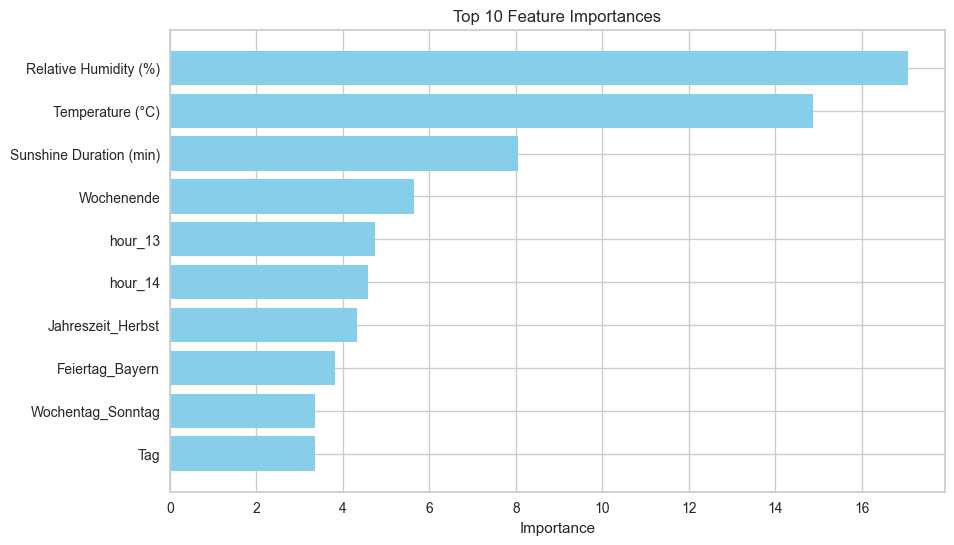

In [214]:
from catboost import CatBoostRegressor
import pandas as pd
import matplotlib.pyplot as plt

if isinstance(model, CatBoostRegressor):
    # Get feature importances
    importances = model.get_feature_importance()

    # Ensure you have feature names, might be needed from setup or data
    feature_names = model.feature_names_

    # Create a DataFrame for easier manipulation
    feature_importances = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })

    # Sort features by importance in descending order
    feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

    # Select top 10 features
    top_10_features = feature_importances.head(10)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(top_10_features['Feature'], top_10_features['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.title('Top 10 Feature Importances')
    plt.gca().invert_yaxis()
    plt.show()

Optimize catboost

onehot encode

In [215]:
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np

# Assuming dfs, cols_for_modeling are already defined as in your code
# Split data into features (X) and target (y)
X = dfs['Falkenstein-Schwellhäusl_in_target'][cols_for_modeling]  # Features
y = dfs['Falkenstein-Schwellhäusl_in_target']['target']               # Target variable

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid
param_grid = {
    'depth': [6, 8],            # Reduced from [6, 8, 10] to [6, 8]
    'learning_rate': [0.01],    # Reduced from [0.01, 0.1, 0.2] to just [0.01]
    'iterations': [500],        # Reduced from [500, 1000] to just [500]
    'l2_leaf_reg': [1, 3]        # Reduced from [1, 3, 5] to [1, 3]
}

# Initialize CatBoostRegressor
model = CatBoostRegressor(learning_rate=0.1, iterations=1000, depth=10, l2_leaf_reg=3)

# GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Predict on the test set with the best estimator
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Compute additional metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
rmsle = np.sqrt(mean_squared_error(np.log1p(y_test), np.log1p(y_pred)))  # Using log transformation for RMSLE
mape = mean_absolute_percentage_error(y_test, y_pred)

# Print additional metrics
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R^2 Score: {r2:.4f}")
print(f"Root Mean Squared Logarithmic Error (RMSLE): {rmsle:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}")


ValueError: 
All the 12 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "_catboost.pyx", line 2383, in _catboost.get_float_feature
  File "_catboost.pyx", line 1188, in _catboost._FloatOrNan
  File "_catboost.pyx", line 983, in _catboost._FloatOrNanFromString
TypeError: Cannot convert 'b'Donnerstag'' to float

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\patricio\.pyenv-win-venv\envs\bf_dssdgx\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\patricio\.pyenv-win-venv\envs\bf_dssdgx\lib\site-packages\catboost\core.py", line 5827, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline,
  File "c:\Users\patricio\.pyenv-win-venv\envs\bf_dssdgx\lib\site-packages\catboost\core.py", line 2385, in _fit
    train_params = self._prepare_train_params(
  File "c:\Users\patricio\.pyenv-win-venv\envs\bf_dssdgx\lib\site-packages\catboost\core.py", line 2265, in _prepare_train_params
    train_pool = _build_train_pool(X, y, cat_features, text_features, embedding_features, pairs,
  File "c:\Users\patricio\.pyenv-win-venv\envs\bf_dssdgx\lib\site-packages\catboost\core.py", line 1503, in _build_train_pool
    train_pool = Pool(X, y, cat_features=cat_features, text_features=text_features, embedding_features=embedding_features, pairs=pairs, weight=sample_weight, group_id=group_id,
  File "c:\Users\patricio\.pyenv-win-venv\envs\bf_dssdgx\lib\site-packages\catboost\core.py", line 848, in __init__
    self._init(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
  File "c:\Users\patricio\.pyenv-win-venv\envs\bf_dssdgx\lib\site-packages\catboost\core.py", line 1481, in _init
    self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
  File "_catboost.pyx", line 4159, in _catboost._PoolBase._init_pool
  File "_catboost.pyx", line 4209, in _catboost._PoolBase._init_pool
  File "_catboost.pyx", line 4025, in _catboost._PoolBase._init_features_order_layout_pool
  File "_catboost.pyx", line 2963, in _catboost._set_features_order_data_pd_data_frame
  File "_catboost.pyx", line 2427, in _catboost.create_num_factor_data
  File "_catboost.pyx", line 2385, in _catboost.get_float_feature
_catboost.CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=9]="Donnerstag": Cannot convert 'b'Donnerstag'' to float

--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "_catboost.pyx", line 2383, in _catboost.get_float_feature
  File "_catboost.pyx", line 1188, in _catboost._FloatOrNan
  File "_catboost.pyx", line 983, in _catboost._FloatOrNanFromString
TypeError: Cannot convert 'b'Freitag'' to float

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\patricio\.pyenv-win-venv\envs\bf_dssdgx\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\patricio\.pyenv-win-venv\envs\bf_dssdgx\lib\site-packages\catboost\core.py", line 5827, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline,
  File "c:\Users\patricio\.pyenv-win-venv\envs\bf_dssdgx\lib\site-packages\catboost\core.py", line 2385, in _fit
    train_params = self._prepare_train_params(
  File "c:\Users\patricio\.pyenv-win-venv\envs\bf_dssdgx\lib\site-packages\catboost\core.py", line 2265, in _prepare_train_params
    train_pool = _build_train_pool(X, y, cat_features, text_features, embedding_features, pairs,
  File "c:\Users\patricio\.pyenv-win-venv\envs\bf_dssdgx\lib\site-packages\catboost\core.py", line 1503, in _build_train_pool
    train_pool = Pool(X, y, cat_features=cat_features, text_features=text_features, embedding_features=embedding_features, pairs=pairs, weight=sample_weight, group_id=group_id,
  File "c:\Users\patricio\.pyenv-win-venv\envs\bf_dssdgx\lib\site-packages\catboost\core.py", line 848, in __init__
    self._init(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
  File "c:\Users\patricio\.pyenv-win-venv\envs\bf_dssdgx\lib\site-packages\catboost\core.py", line 1481, in _init
    self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
  File "_catboost.pyx", line 4159, in _catboost._PoolBase._init_pool
  File "_catboost.pyx", line 4209, in _catboost._PoolBase._init_pool
  File "_catboost.pyx", line 4025, in _catboost._PoolBase._init_features_order_layout_pool
  File "_catboost.pyx", line 2963, in _catboost._set_features_order_data_pd_data_frame
  File "_catboost.pyx", line 2427, in _catboost.create_num_factor_data
  File "_catboost.pyx", line 2385, in _catboost.get_float_feature
_catboost.CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=9]="Freitag": Cannot convert 'b'Freitag'' to float
